# Circuit function analytics: Stats summarizing behavior (precision, sensitivity, response time...)



In [1]:

from functools import partial
import numpy as np
import jax.numpy as jnp
import jax
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import bioreaction
from bioreaction.simulation.med_sim import get_int_med_model, MedSimParams, MedSimInternalState
from bioreaction.model.data_tools import construct_model_fromnames
from bioreaction.simulation.basic_sim import basic_de_sim, convert_model, BasicSimParams, BasicSimState


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.utils.results.analytics.timeseries import generate_analytics
from src.utils.signal.signals_new import SignalFuncs

In [ ]:

def update_model_rates(model, a=None, d=None, ka=None, kd=None):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            if a is not None:
                model.reactions[i].forward_rate = a[model.species.index(
                    r.output[0])]
                model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            if d is not None:
                model.reactions[i].forward_rate = d[model.species.index(
                    r.input[0])]
                model.reactions[i].reverse_rate = 0
        else:
            if ka is not None:
                model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                    model.species.index(r.input[1])]
            if kd is not None:
                model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                    model.species.index(r.input[1])]
    return model


Define some parameters.

In [ ]:
num_species = 3
input_species_idx = 0
output_species_idx = 1

Keq = np.array(
    [[1, 2, 1],
     [2, 1, 0.5],
     [1, 0.5, 2]]
)
# From src/utils/common/configs/RNA_circuit/molecular_params.json
a=np.ones(3) * 0.08333
d=np.ones(3) * 0.0008333
ka=np.ones_like(Keq)
kd=ka/Keq

t0 = 0
t1 = 100
dt0 = 0.1
t = np.arange(t0, t1) * dt0
t_sig = t1/2
target = 100
baseline = 20
overshoot = 10
overshoot_height = target + 10

In [ ]:


med_model = bioreaction.templates.generate_rnabinding_medsim(
    num_species=num_species,
    a=a, d=d, ka=ka,
    kd=ka/Keq,
    impulse_idx=0
)

s0 = np.concatenate([np.array([1.0, 1.0, 1.0]), np.zeros(len(med_model.species[num_species:]))])

# impulse = Impulse(target=med_model.species[:num_species][input_species_idx], delta_target=20, time=100.0, impulse_width=0.0)
med_model.impulses = []
poiss_simmed = jnp.zeros(len(med_model.reactions))
brown_simmed = jnp.zeros(len(med_model.reactions))

# Making the params for the simulation, how things are simutated and for how long.
int_med_params = MedSimParams(delta_t= 0.01, t_start=0.0, t_end = 1000.0, poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)
int_med_model = get_int_med_model(med_model)
int_med_state = MedSimInternalState(concentrations=s0, other_factors=jnp.zeros(len(med_model.other_factors)))

Make some fake signals.

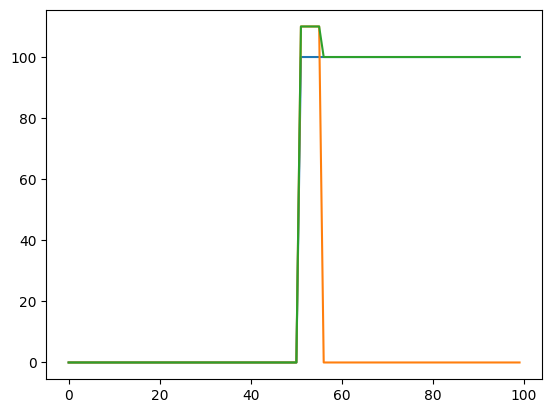

In [ ]:
i = 0
plt.plot(np.array(SignalFuncs.step_function_integrated(t, t_sig + i, target=target + i)))
plt.plot(SignalFuncs.step_function_integrated(t, t_sig + i, target=overshoot_height + i) - SignalFuncs.step_function_integrated(t, t_sig + i + overshoot/2, target=overshoot_height + i))
plt.plot(SignalFuncs.step_function_integrated(t, t_sig + i, target=target + i) + 
         SignalFuncs.step_function_integrated(t, t_sig + i, target=overshoot + i) - 
         SignalFuncs.step_function_integrated(t, t_sig + i + overshoot/2, target=overshoot + i))
plt.title('Toy input signals')

In [ ]:

signal_onehot = 1 * \
    np.array([f == med_model.species[input_species_idx] for f in med_model.species])

data = np.asarray([
    SignalFuncs.step_function_integrated(t, t_sig + i, target=target + i) + 
    SignalFuncs.step_function_integrated(t, t_sig + i, target=overshoot) - 
    SignalFuncs.step_function_integrated(t, t_sig + i + overshoot/2, target=overshoot) for i in range(len(med_model.species))]) + baseline
data[input_species_idx] = np.array(SignalFuncs.step_function_integrated(t, t_sig, target=target)) + baseline
data[2] = np.array(SignalFuncs.step_function_integrated(t, t_sig, target=target)) + baseline
data[3] = baseline
ref_circuit_data = np.asarray([
    SignalFuncs.step_function_integrated(t, t_sig + i * 2, target=target + i * 2) + 
    SignalFuncs.step_function_integrated(t, t_sig + i * 2, target=overshoot) - 
    SignalFuncs.step_function_integrated(t, t_sig + i * 2 + overshoot/2, target=overshoot) for i in range(len(med_model.species))]) + baseline
ref_circuit_data[input_species_idx] = np.array(SignalFuncs.step_function_integrated(t, t_sig, target=target)) + baseline
ref_circuit_data[2] = np.array(SignalFuncs.step_function_integrated(t, t_sig, target=target)) + baseline
ref_circuit_data[3] = baseline

data_rev = (data.max() + data.min()) - data
ref_circuit_data_rev = (ref_circuit_data.max() + ref_circuit_data.min()) - ref_circuit_data

analytics = {k: np.array(v) for k, v in
                partial(generate_analytics, time=t, labels=med_model.species,
                        signal_idxs=[int(np.where(signal_onehot == 1)[0])],
                        signal_time=t_sig,
                        ref_circuit_data=ref_circuit_data)(data).items()
                }
analytics_rev = {k: np.array(v) for k, v in
                    partial(generate_analytics, time=t, labels=med_model.species,
                            signal_idxs=[int(np.where(signal_onehot == 1)[0])],
                            signal_time=t_sig,
                            ref_circuit_data=ref_circuit_data_rev)(data_rev).items()
                    }

In [ ]:
analytics.keys()

dict_keys(['first_derivative', 'initial_steady_states', 'max_amount', 'min_amount', 'RMSE', 'steady_states', 'final_deriv', 'fold_change', 'overshoot', 'precision_wrt_species-0', 'response_time_wrt_species-0', 'sensitivity_wrt_species-0', 'first_derivative_diff_to_base_circuit', 'initial_steady_states_diff_to_base_circuit', 'max_amount_diff_to_base_circuit', 'min_amount_diff_to_base_circuit', 'RMSE_diff_to_base_circuit', 'steady_states_diff_to_base_circuit', 'final_deriv_diff_to_base_circuit', 'fold_change_diff_to_base_circuit', 'overshoot_diff_to_base_circuit', 'precision_wrt_species-0_diff_to_base_circuit', 'response_time_wrt_species-0_diff_to_base_circuit', 'sensitivity_wrt_species-0_diff_to_base_circuit', 'first_derivative_ratio_from_mutation_to_base', 'initial_steady_states_ratio_from_mutation_to_base', 'max_amount_ratio_from_mutation_to_base', 'min_amount_ratio_from_mutation_to_base', 'RMSE_ratio_from_mutation_to_base', 'steady_states_ratio_from_mutation_to_base', 'final_deriv_ra

Text(0.5, 1.0, 'Reference inverse')

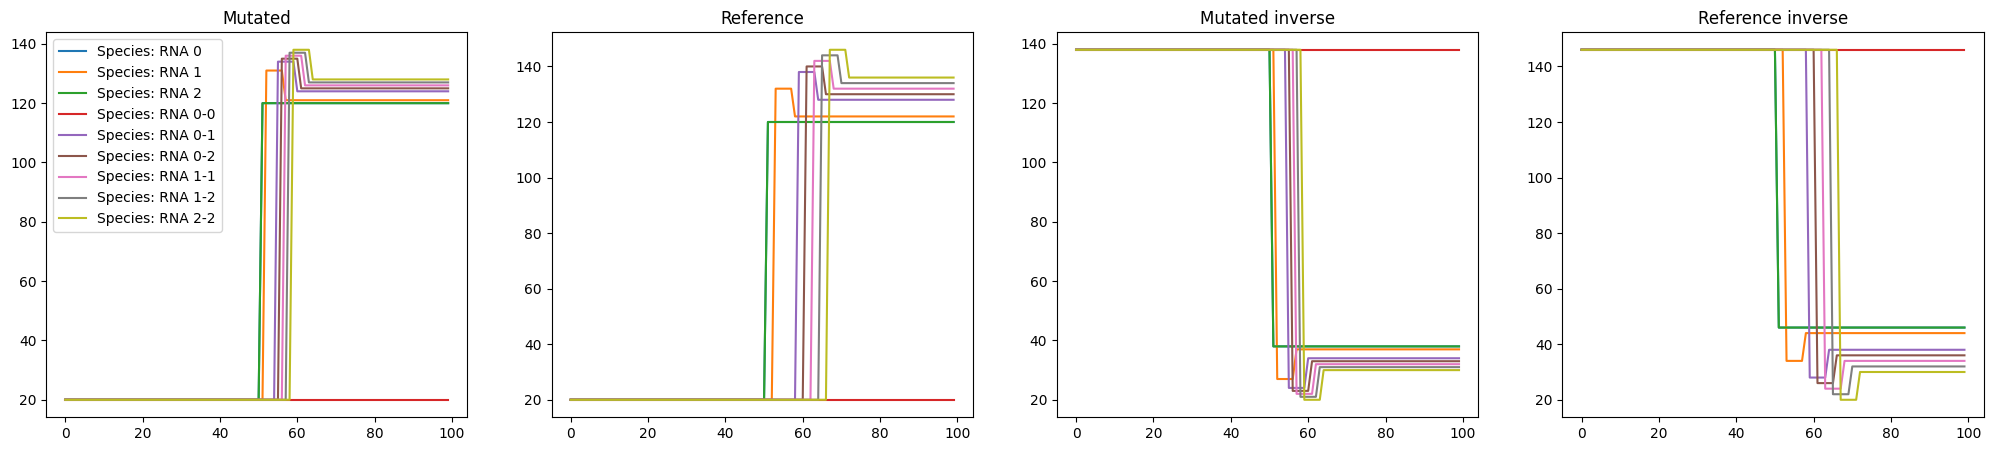

In [ ]:
plt.figure(figsize=(25,5))
ax = plt.subplot(1,4,1)
plt.plot(np.swapaxes(data, 0, 1))
plt.legend(med_model.species)
plt.title('Mutated')
ax = plt.subplot(1,4,2)
plt.plot(np.swapaxes(ref_circuit_data, 0, 1))
plt.title('Reference')
ax = plt.subplot(1,4,3)
plt.plot(np.swapaxes(data_rev, 0, 1))
plt.title('Mutated inverse')
ax = plt.subplot(1,4,4)
plt.plot(np.swapaxes(ref_circuit_data_rev, 0, 1))
plt.title('Reference inverse')

Precision and sensitivity: same for inverse response.

Text(0, 0.5, 'Precision')

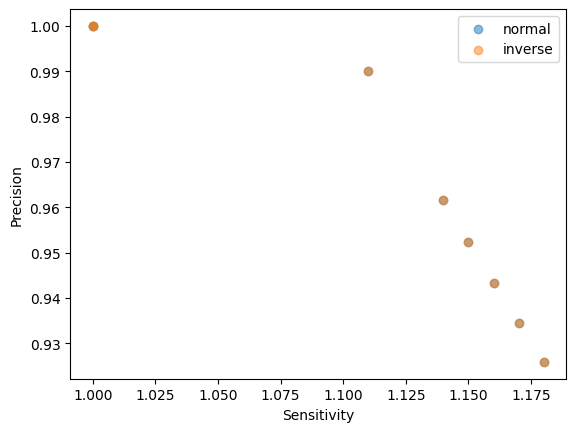

In [ ]:
plt.scatter(analytics['sensitivity_wrt_species-0'], analytics['precision_wrt_species-0'], alpha=0.5)
plt.scatter(analytics_rev['sensitivity_wrt_species-0'], analytics_rev['precision_wrt_species-0'], alpha=0.5)
plt.legend(['normal', 'inverse'])
plt.xlabel('Sensitivity')
plt.ylabel('Precision')

Overshoot and time response:

Expected overshoots:  [ 0 10  0  0 10 10 10 10 10]


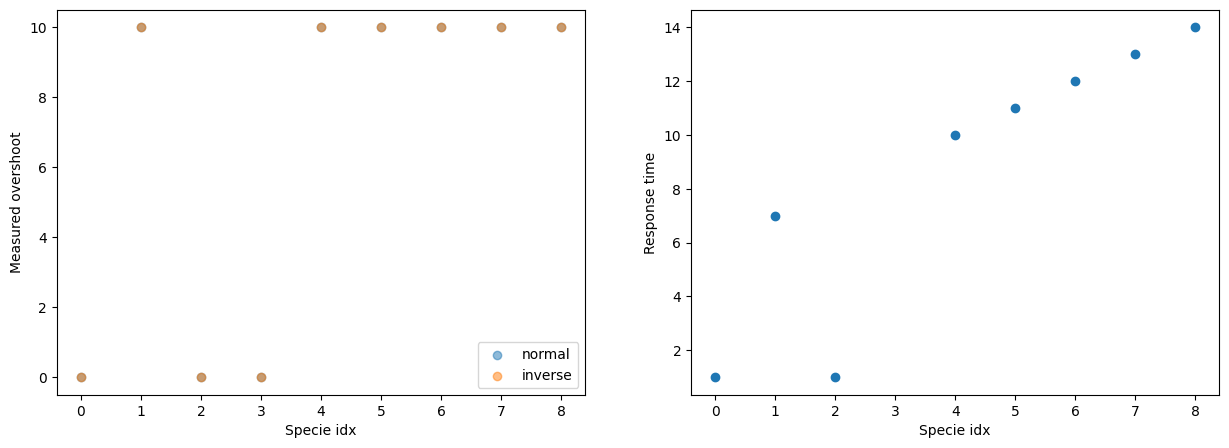

In [ ]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)
plt.scatter(np.arange(len(med_model.species)), analytics['overshoot'], alpha=0.5)
plt.scatter(np.arange(len(med_model.species)), analytics_rev['overshoot'], alpha=0.5)
plt.legend(['normal', 'inverse'])
plt.xlabel('Specie idx')
plt.ylabel('Measured overshoot')

ax = plt.subplot(1,2,2)
plt.scatter(np.arange(len(med_model.species)), analytics['response_time_wrt_species-0'])
plt.xlabel('Specie idx')
plt.ylabel('Response time')

print('Expected overshoots: ', data.max(axis=1) - data[:, -1])

In [ ]:
steady_states = np.expand_dims(data[:, -1], axis=1)


margin = 0.05
is_steadystate = ~((data > (steady_states + steady_states * margin)
                    ) | (data < (steady_states - steady_states * margin)))

argmax_workaround = jnp.ones_like(
    steady_states) * jnp.arange(len(t)) == jnp.expand_dims(np.argmax(is_steadystate, axis=1), axis=1)
tstop = jnp.max(t * argmax_workaround, axis=1)

response_times = jnp.where(
    (tstop != t[-1]) & (tstop >= t_sig),
    tstop - t_sig,
    np.inf
)
response_times


Array([ 1.,  7.,  1., inf, 10., 11., 12., 13., 14.],      dtype=float32, weak_type=True)

In [ ]:
jnp.expand_dims(np.argmax(is_steadystate, axis=1), axis=1)[3]

Array([0], dtype=int32)